# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your
functionality in stages which is required to successfully complete
this project. If additional code is required that cannot be included
in the notebook, be sure that the Python code is successfully imported
and included in your submission, if necessary. Sections that begin
with **'Implementation'** in the header indicate where you should
begin your implementation for your project. Note that some sections of
implementation are optional, and will be marked with **'Optional'** in
the header.

In addition to implementing code, there will be questions that you
must answer which relate to the project and your implementation. Each
section where you will answer a question is preceded by a
**'Question'** header. Carefully read each question and provide
thorough answers in the following text boxes that begin with
**'Answer:'**. Your project submission will be evaluated based on your
answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift +
   Enter** keyboard shortcut. In addition, Markdown cells can be
   edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Import modules

from collections import deque
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import math
import numpy as np
import pdb
import pickle
import tensorflow as tf
import os


/home/dventimi/anaconda3/envs/CarND-Traffic-Signs/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../train.p'
testing_file = '../test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples

n_train = train['labels'].shape[0]

# TODO: Number of testing examples.

n_test = test['labels'].shape[0]

# TODO: What's the shape of an traffic sign image?

image_shape = train['features'].shape[1:]

# TODO: How many unique classes/labels there are in the dataset.

# The labels are numeric (integers), so we could take advantage of the
# natural ordering of numbers by subtracting the minimum label value
# from the maximum label value and adding 1 (because both the min
# value AND the max value are represented among the labels).

n_classes = max(train['labels'])-min(train['labels'])+1

# However, by doing this we implicitly assume that every possible
# label (i.e., integer) in that interval is represented in the training
# set.  That need not be the case.  Therefore, a more reliable way is
# to count the number of unique elements within set of labels.

import numpy as np
n_classes = len(np.unique(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled
file(s). This is open ended, suggestions include: plotting traffic
sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/)
[examples](http://matplotlib.org/examples/index.html) and
[gallery](http://matplotlib.org/gallery.html) pages are a great
resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If
  you wish to do more, come back to it after you've completed the rest
  of the sections.

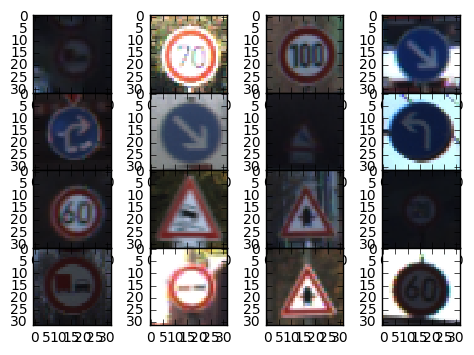

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# Sample of n sign images
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.ion()
n = 16
columns = 4
rows = n // columns + int(n % columns > 0)
fig = plt.figure()
plt.subplots_adjust(wspace=0.001, hspace=0.001)
for t in zip(range(n), np.random.choice(np.array(range(n_train)), n, False)):
    fig.add_subplot(rows,columns,t[0]+1)
    plt.imshow(train['features'][t[1],], interpolation='nearest')

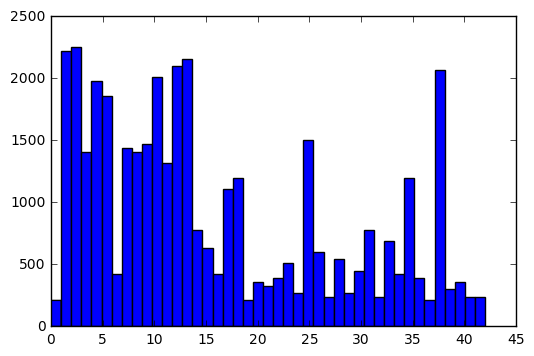

In [5]:
# Count of each sign (histogram)

fig = plt.figure()
h = plt.hist(train['labels'], n_classes)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize
traffic signs. Train and test your model on the [German Traffic Sign
Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this
problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this
problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's
not required to be familiar with the approach used in the paper but,
it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the
  [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81)
  at the end of the CNN lesson is a solid starting point. You'll have
  to change the number of classes and possibly the preprocessing, but
  aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement
the first step of your project. Once you have completed your
implementation and are satisfied with the results, be sure to
thoroughly answer the questions that follow.

In [6]:
# Set parameters

ACCURACY_THRESHOLD = 0.01
BATCH_SIZE = 100
LEARNING_RATE = 0.001
MAX_EPOCHS = 100
MIN_EPOCHS = 10
MU = 0
SIGMA = 0.1
VALIDATION_FRACTION = 0.2


In [7]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Shuffle the training data

train['features'], train['labels'] = shuffle(X_train, y_train)

# Scale images

train['features'] = (train['features']-128.)/128.
test['features'] = (test['features']-128.)/128.


### Question 1 

_Describe how you preprocessed the data. Why did you choose that
technique?_

**Answer:**

In [8]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# Reserve a portion of training data as validation data

X_train, X_valid, y_train, y_valid = train_test_split(train['features'], train['labels'], test_size=VALIDATION_FRACTION, random_state=42)
X_tests, y_tests = test['features'], test['labels']
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_tests = X_tests.shape[0]


### Question 2

_Describe how you set up the training, validation and testing data for
your model. **Optional**: If you generated additional data, how did
you generate the data? Why did you generate the data? What are the
differences in the new dataset (with generated data) from the original
dataset?_

**Answer:**

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Define architecture

def SignNet(x, keep_prob, n_classes):    
    # Layer 1: Convolutional. Input = 32x32xinput_channels. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, x.get_shape()[3].value, 6), mean = MU, stddev = SIGMA), name='conv1_W')
    conv1_b = tf.Variable(tf.zeros(6), name='conv1_b')
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = MU, stddev = SIGMA), name='conv2_W')
    conv2_b = tf.Variable(tf.zeros(16), name='conv2_b')
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = MU, stddev = SIGMA), name='fc1_W')
    fc1_b = tf.Variable(tf.zeros(120), name='fc1_b')
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    # Activation.
    fc1    = tf.nn.relu(fc1)
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = MU, stddev = SIGMA), name='fc2_W')
    fc2_b  = tf.Variable(tf.zeros(84), name='fc2_b')
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    # Activation.
    fc2    = tf.nn.relu(fc2)
    # Dropout
    fc2_drop = tf.nn.dropout(fc2, keep_prob)
    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = MU, stddev = SIGMA), name='fc3_W')
    fc3_b  = tf.Variable(tf.zeros(n_classes), name='fc3_b')
    logits = tf.matmul(fc2_drop, fc3_W) + fc3_b
    return logits


### Question 3

_What does your final architecture look like? (Type of model, layers,
sizes, connectivity, etc.)  For reference on how to build a deep
neural network using TensorFlow, see [Deep Neural Network in
TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432)
from the classroom._


**Answer:**

In [10]:
### Train your model here.
### Feel free to use as many code cells as needed.

# Define evaluation function

def evaluate(sess, X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Define the model

tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None,) + X_train.shape[1:])
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)
logits = SignNet(x, keep_prob, n_classes)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Train the model, validate, and test

def train_model(X_train, y_train, BATCH_SIZE):
    accuracy_window = deque(np.zeros(5, dtype='f'), 5)
    accuracy_means = deque(np.zeros(2, dtype='f'), 2)
    num_examples = len(X_train)
    for i in range(MAX_EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
        valid_accuracy = evaluate(sess, X_valid, y_valid)
        train_accuracy = evaluate(sess, X_train, y_train)
        accuracy_window.append(valid_accuracy)
        mean_accuracy = np.mean(accuracy_window)
        accuracy_means.append(mean_accuracy)
        accuracy_delta = accuracy_means[1]-accuracy_means[0]
        print("{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}".format((i+1), valid_accuracy, mean_accuracy, accuracy_delta, train_accuracy))
        if (abs(accuracy_delta)<ACCURACY_THRESHOLD and i>MIN_EPOCHS):
            break
        
saver = tf.train.Saver()
sess = tf.Session()
try:
    saver.restore(sess, "model.ckpt")
except:
    sess.run(tf.initialize_all_variables())
    train_model(X_train, y_train, BATCH_SIZE)
    save_path = saver.save(sess, "model.ckpt")


1	0.765	0.153	0.153	0.775
2	0.906	0.334	0.181	0.913
3	0.935	0.521	0.187	0.944
4	0.957	0.713	0.191	0.963
5	0.968	0.906	0.194	0.976
6	0.968	0.947	0.041	0.979
7	0.974	0.960	0.014	0.983
8	0.980	0.969	0.009	0.989
9	0.982	0.975	0.005	0.990
10	0.977	0.976	0.002	0.988
11	0.982	0.979	0.003	0.990
12	0.984	0.981	0.002	0.991


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs,
hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this
problem? It may have been a process of trial and error, in which case,
outline the steps you took to get to the final solution and why you
chose those steps. Perhaps your solution involved an already well
known implementation or architecture. In this case, discuss why you
think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or
around you (at least five), and run them through your classifier on
your computer to produce example results. The classifier might not
recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the
class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement
the first step of your project. Once you have completed your
implementation and are satisfied with the results, be sure to
thoroughly answer the questions that follow.

In [11]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.


### Question 6

_Choose five candidate images of traffic signs and provide them in the
report. Are there any particular qualities of the image(s) that might
make classification difficult? It could be helpful to plot the images
in the notebook._



**Answer:**

In [12]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when
compared to testing on the dataset? The simplest way to do this check
the accuracy of the predictions. For example, if the model predicted 1
out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using
`signnames.csv` (same directory). This file has a mapping from the
class id (0-42) to the corresponding sign name. So, you could take the
class id the model outputs, lookup the name in `signnames.csv` and see
if it matches the sign from the image._


**Answer:**

In [13]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the
top k predictions. So if k=3, for each sign, it'll return the 3
largest probabilities (out of a possible 43) and the correspoding
class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842, 0.24879643,
0.12789202]`, you can confirm these are the 3 largest probabilities in
`a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations
    and successfully answered each question above, you may finalize
    your work by exporting the iPython Notebook as an HTML
    document. You can do this by using the menu above and navigating
    to \n", "**File -> Download as -> HTML (.html)**. Include the
    finished document along with this notebook as your submission.